# Import packages

In [1]:
import torch
from tabulate import tabulate
from scipy.io import savemat
import numpy as np
import random
import torch.nn as nn
import torchvision
import time
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import sys
import random
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from numpy import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [2]:
class mydataset(Dataset):
  def __init__(self , datas , labels):
    super(mydataset,self).__init__()
    self.datas = torch.tensor(datas , dtype=torch.float)
    self.labels = torch.tensor(labels , dtype=torch.float)

  def __getitem__(self, index):
    return self.datas[index] , self.labels[index]

  def __len__(self):
    return self.datas.shape[0]

## OxfordIIITPet

In [3]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128,128))])
batchsize = 64


trainset = torchvision.datasets.OxfordIIITPet(root = '/content/' ,download = True,split='trainval', transform = transforms)
testset = torchvision.datasets.OxfordIIITPet(root = '/content/' ,download = True,split='test', transform = transforms)


trainloader = DataLoader(trainset , batch_size = batchsize , shuffle = True , num_workers = 2)
testloader = DataLoader(testset , batch_size = batchsize , shuffle = True , num_workers = 2)

100%|██████████| 791918971/791918971 [00:29<00:00, 26852552.97it/s]


Extracting /content/oxford-iiit-pet/images.tar.gz to /content/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11249417.05it/s]


Extracting /content/oxford-iiit-pet/annotations.tar.gz to /content/oxford-iiit-pet


## Flower 102


In [ ]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128,128))])
batchsize = 64


trainset = torchvision.datasets.Flowers102(root = '/content/' ,download = True,split='train', transform = transforms)
testset = torchvision.datasets.Flowers102(root = '/content/' ,download = True,split='test', transform = transforms)


trainloader = DataLoader(trainset , batch_size = batchsize , shuffle = True , num_workers = 2)
testloader = DataLoader(testset , batch_size = batchsize , shuffle = True , num_workers = 2)

## FGVCAircraft

In [ ]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128,128))])
batchsize = 64

trainset = torchvision.datasets.FGVCAircraft(root='/content/', split='train' ,transform= transforms,random_state = 123, download= True)
testset = torchvision.datasets.FGVCAircraft(root='/content/', split='test' ,transform= transforms,random_state = 123, download= True)

trainloader = DataLoader(trainset , batch_size = batchsize , shuffle = True , num_workers = 2)
testloader = DataLoader(testset , batch_size = batchsize , shuffle = False , num_workers = 2)

# Corrupting image

In [ ]:
import random
w=random.sample(range(1, 500), 80)
SIZE=trainset.__getitem__(1)[0].shape # just for extract the shapes
num_data = 1020 #Chose the exact number of train and test datas
H_train=np.zeros((num_data,SIZE[0],SIZE[1],SIZE[2]), dtype=float)
H_train_noisy=np.zeros((num_data,SIZE[0],SIZE[1],SIZE[2]), dtype=float)

r,c = 2,2
random = [np.random.randint(0, num_data) for _ in range(r*c)]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
NOISE_LEVEL = 21 #change diffrent noise
x = (255/NOISE_LEVEL)*1
for i in range(0,num_data):
  H = trainset.__getitem__(i)[0]
  H_train[i,:,:,:]= H
  N = np.random.normal(0, 1/x , size=(SIZE[0],SIZE[1], SIZE[2]))
  H_train_noisy[i,:,:,:]= H + N

print(H_train.shape,H_train_noisy.shape)

(102, 3, 128, 128) (102, 3, 128, 128)


In [ ]:
nmse2=torch.zeros((num_data,1), dtype=torch.float32)
for n in range(num_data):
    MSE=((H_train[n,:,:,:]-H_train_noisy[n,:,:,:])**2).sum()
    norm_real=((H_train[n,:,:,:])**2).sum()
    nmse2[n]=MSE/norm_real
print('NMSE = ',nmse2.sum()/(num_data))

NMSE =  tensor(0.0349)


In [ ]:
def psnr(prediction, target):
    mse = torch.mean((prediction - target) ** 2)
    if mse == 0:
        return float('inf')  # Prevent division by zero
    max_pixel_value = 1.0  # Assuming input images are normalized to [0, 1]
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()  # Extract the scalar value


In [ ]:
def plot_image_train(r,c,data):
  d=[]
  i = 0
  for k in (random):
    image =data[k,:,:,:]
    image = np.transpose(image,(1,2,0))
    d.append(image)
  fig, axarr = plt.subplots(r,c)

  for row in range(r):
    for col in range(c):
      axarr[row,col].imshow(d[i])
      i += 1


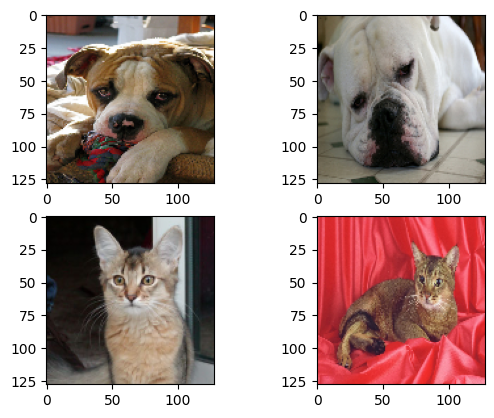

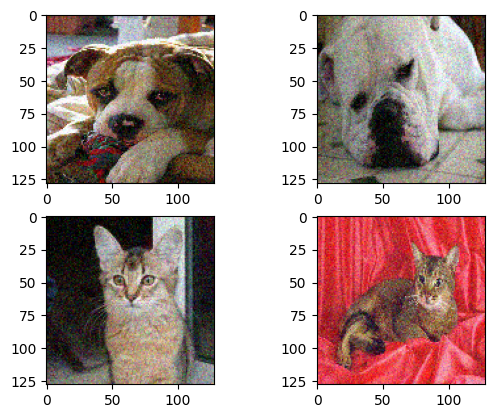

In [ ]:
plot_image_train(r,c,H_train)
plt.savefig('train{}x{}orginal {}NOISE_LEVEL.png'.format(r,c,NOISE_LEVEL))

plot_image_train(r,c,H_train_noisy)
plt.savefig('train{}x{}_corrupted {}NOISE_LEVEL.png'.format(r,c,NOISE_LEVEL))


In [ ]:
batch_size = 16

trainset = mydataset(H_train_noisy , H_train)
trainloader = DataLoader(trainset , batch_size = batch_size , shuffle = False, drop_last=True)
H_train_noisy,H_train = [],[]

# GAN

## ConvBlock

In [ ]:
class ConvBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            discriminator=False,
            use_act=True,
            use_bn=True,
            **kwargs,
    ):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
      # print('1',type(x))
      x = self.cnn(x)
      # print('2',type(x))
      x = self.bn(x)
      # print('3',type(x))
      x = self.act(x)
      # print('4',type(x))
      # out = self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))
      return x



## UpsampleBlock

In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))

## ResidualBlock

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x


## Generator & Discriminator

In [ ]:
'''''''''''''''''''''''''''''''''''''''''''Generator'''''''''''''''''''''''''''''''''''''''''''
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=6):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels , out_channels=64 , kernel_size=3 , padding='same'),
            nn.ReLU()
        )
        self.conv_layers = self.Denoise_block(64, 9)
        self.layers3 = nn.Conv2d(in_channels=64,out_channels=in_channels,kernel_size=3,stride=1,padding='same')

        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2), UpsampleBlock(num_channels, 2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=4, padding=4)


    def Denoise_block(self, num_filters, num_layers):
      layers = []
      for _ in range(num_layers):
          layers.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1))
          layers.append(nn.BatchNorm2d(num_filters, eps=1e-3))
          layers.append(nn.PReLU())
      return nn.Sequential(*layers)



    def forward(self, x):
        out1 = self.layers(x)
        out1 = self.conv_layers(out1)
        out1 = self.layers3(out1)
        out1 -= x

        initial = self.initial(out1)
        out2 = self.residuals(initial)
        out2 = self.convblock(out2) + initial
        out2 = self.upsamples(out2)
        return torch.tanh(self.final(out2))



'''''''''''''''''''''''''''''''''''''''''Discriminator'''''''''''''''''''''''''''''''''''''''''
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_act=True,
                    use_bn=False if idx == 0 else True,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.conv = nn.Sequential(nn.Conv2d(in_channels=512,out_channels=32,kernel_size=1),
                                  nn.LeakyReLU(),
                                  nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4,stride=4),
                                  )

        self.linear = nn.Sequential(

            nn.Flatten()

        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.conv(x)
        x = self.linear(x)

        x = torch.reshape(x, (batch_size, SIZE[0], SIZE[1], SIZE[2]))
        return x



In [ ]:
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
# gen

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The gen has {count_parameters(gen):,} trainable parameters')
print(f'The disc has {count_parameters(disc):,} trainable parameters')


# Default setting

In [ ]:
LEARNING_RATE=0.0002
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.MSELoss()
criterion = nn.MSELoss()

In [ ]:
'''
  this class is for calculating the final loss of each epoch
'''
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import logging
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('SRGAN: ')

# Train

In [ ]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


In [ ]:
discloss = []
genloss = []
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce):
    total_loss_gen = AverageMeter()
    total_loss_dis = AverageMeter()
    for (x, label) in tqdm(loader, leave=True):
        label = label.to(device)
        x = x.to(device)

        fake = gen(x)
        disc_real = disc(label)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real
        total_loss_dis.update(loss_disc)

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        final_gen_loss = criterion(fake, label)
        gen_loss = final_gen_loss + adversarial_loss
        total_loss_gen.update(gen_loss)

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

#################################################### SAVING GENERATOR AND DISCRIMNATOR ################################################
    if epoch % 10== 0 :
      path_gen = 'Generator_epoch_{} NOISE_LEVEL={}.pth.tar'.format(epoch,NOISE_LEVEL)
      path_disc = 'Discrimnator_epoch_{} NOISE_LEVEL={}.pth.tar'.format(epoch,NOISE_LEVEL)

      save_checkpoint(gen, opt_gen, filename=path_gen)
      save_checkpoint(disc, opt_disc, filename=path_disc)


    discloss.append(total_loss_dis.avg.cpu().detach().numpy())
    genloss.append(total_loss_gen.avg.cpu().detach().numpy())

    logger.info(f'Train: Epoch:{epoch}/{end} \t Loss_Generator:{total_loss_gen.avg:.4}')
    logger.info(f'Train: Epoch:{epoch}/{end} \t Loss_Discrimnator:{total_loss_dis.avg:.4}')

# test

In [ ]:
num_data_test = 6149 #Chose the exact number of train and test datas
H_test=np.zeros((num_data_test,SIZE[0],SIZE[1],SIZE[2]), dtype=float)
H_test_noisy=np.zeros((num_data_test,SIZE[0],SIZE[1],SIZE[2]), dtype=float)

x = (255/NOISE_LEVEL)*1

for i in range(0,num_data_test):
  H = testset.__getitem__(i)[0]
  H_test[i,:,:,:]= H
  N = np.random.normal(0, 1/x , size=(SIZE[0],SIZE[1], SIZE[2]))
  H_test_noisy[i,:,:,:]= H + N

print(H_test.shape,H_test_noisy.shape)

(6149, 3, 128, 128) (6149, 3, 128, 128)


In [ ]:
batch_test = 10
testset = mydataset(H_test_noisy , H_test)
testloader = DataLoader(testset , batch_size = batch_test , shuffle = True, drop_last=True)

In [ ]:
data_num_test=batch_test

def test(testloader,model):
  psnrs=np.zeros((1000,1), dtype=float16)
  nmse=np.zeros((1000,1), dtype=float16)
  k = 0
  model.eval()
  for (input,label) in tqdm(testloader):
    nmse2=torch.zeros((data_num_test,1), dtype=torch.float16)

    input,label = input.to(device),label.to(device)
    decoded_channel = model(input)
    b = psnr(decoded_channel , label)

    for n in range(batch_test):
      MSE=((label[n,:,:,:]-decoded_channel[n,:,:,:])**2).sum()
      norm_real=((label[n,:,:,:])**2).sum()
      nmse2[n]=MSE/norm_real

    a = nmse2.sum()

    nmse[k] = a.detach().numpy()
    psnrs[k] = b
    # psnr[k] = a
    k = k + 1

  return psnrs, nmse


# Training phase

In [ ]:
# load_gen= '/content/drive/MyDrive/gen_e30_11468.pth.tar'
# load_checkpoint(load_gen,gen,opt_gen,LEARNING_RATE)
# load_disc= '/content/drive/MyDrive/disc_e3011468.pth.tar'
# load_checkpoint(load_disc,disc,opt_disc,LEARNING_RATE)

In [ ]:
start , end = 1 , 101
NMSE_test = []
PSNR_test = []


for epoch in range (start , end):
  train_fn(trainloader, disc, gen, opt_gen, opt_disc, mse, bce)
  psnrs, nmse = test(testloader,gen)

  a = nmse.sum()/(num_data_test//10)
  b = psnrs.sum()/(num_data_test//10)

  NMSE_test.append(a)
  PSNR_test.append(b)

  print('NMSE for test is:\t',a)
  print('PSNR for test is:\t',b)

  print('---------------------------------------------------------')
  print('---------------------------------------------------------')

100%|██████████| 63/63 [01:02<00:00,  1.01it/s]
INFO:SRGAN: :Train: Epoch:1/101 	 Loss_Generator:0.02471
INFO:SRGAN: :Train: Epoch:1/101 	 Loss_Discrimnator:0.663
100%|██████████| 614/614 [01:45<00:00,  5.82it/s]


NMSE for test is:	 0.5272801302931596
PSNR for test is:	 19.791530944625407
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:2/101 	 Loss_Generator:0.009018
INFO:SRGAN: :Train: Epoch:2/101 	 Loss_Discrimnator:0.4966
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.3096498371335505
PSNR for test is:	 22.319218241042346
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:3/101 	 Loss_Generator:0.004844
INFO:SRGAN: :Train: Epoch:3/101 	 Loss_Discrimnator:0.4468
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.2094869706840391
PSNR for test is:	 24.026058631921824
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:4/101 	 Loss_Generator:0.003874
INFO:SRGAN: :Train: Epoch:4/101 	 Loss_Discrimnator:0.4054
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.1674470684039088
PSNR for test is:	 25.01628664495114
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:5/101 	 Loss_Generator:0.003343
INFO:SRGAN: :Train: Epoch:5/101 	 Loss_Discrimnator:0.3887
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.14800488599348535
PSNR for test is:	 25.550488599348533
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:6/101 	 Loss_Generator:0.003114
INFO:SRGAN: :Train: Epoch:6/101 	 Loss_Discrimnator:0.356
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.1310057003257329
PSNR for test is:	 26.09771986970684
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:7/101 	 Loss_Generator:0.002962
INFO:SRGAN: :Train: Epoch:7/101 	 Loss_Discrimnator:0.3316
100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.12734120521172637
PSNR for test is:	 26.188925081433226
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:8/101 	 Loss_Generator:0.002765
INFO:SRGAN: :Train: Epoch:8/101 	 Loss_Discrimnator:0.3293
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.11482084690553745
PSNR for test is:	 26.67100977198697
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:9/101 	 Loss_Generator:0.002707
INFO:SRGAN: :Train: Epoch:9/101 	 Loss_Discrimnator:0.3536
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.11278501628664495
PSNR for test is:	 26.736156351791532
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.03it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:10/101 	 Loss_Generator:0.002995
INFO:SRGAN: :Train: Epoch:10/101 	 Loss_Discrimnator:0.3967


=> Saving checkpoint


100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.12520358306188925
PSNR for test is:	 26.28013029315961
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:11/101 	 Loss_Generator:0.002825
INFO:SRGAN: :Train: Epoch:11/101 	 Loss_Discrimnator:0.3999
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.12734120521172637
PSNR for test is:	 26.267100977198698
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:12/101 	 Loss_Generator:0.002469
INFO:SRGAN: :Train: Epoch:12/101 	 Loss_Discrimnator:0.4306
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.10189332247557004
PSNR for test is:	 27.179153094462542
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:13/101 	 Loss_Generator:0.002188
INFO:SRGAN: :Train: Epoch:13/101 	 Loss_Discrimnator:0.4312
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.09349552117263844
PSNR for test is:	 27.570032573289904
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:14/101 	 Loss_Generator:0.002051
INFO:SRGAN: :Train: Epoch:14/101 	 Loss_Discrimnator:0.4614
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.09100162866449511
PSNR for test is:	 27.6742671009772
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:15/101 	 Loss_Generator:0.002059
INFO:SRGAN: :Train: Epoch:15/101 	 Loss_Discrimnator:0.4418
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.09298656351791532
PSNR for test is:	 27.596091205211728
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:16/101 	 Loss_Generator:0.002059
INFO:SRGAN: :Train: Epoch:16/101 	 Loss_Discrimnator:0.4277
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.09288477198697069
PSNR for test is:	 27.596091205211728
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:17/101 	 Loss_Generator:0.002005
INFO:SRGAN: :Train: Epoch:17/101 	 Loss_Discrimnator:0.4415
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.09049267100977199
PSNR for test is:	 27.72638436482085
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:18/101 	 Loss_Generator:0.001991
INFO:SRGAN: :Train: Epoch:18/101 	 Loss_Discrimnator:0.4335
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.08876221498371335
PSNR for test is:	 27.80456026058632
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:19/101 	 Loss_Generator:0.001975
INFO:SRGAN: :Train: Epoch:19/101 	 Loss_Discrimnator:0.4354
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.08428338762214983
PSNR for test is:	 28.01302931596091
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:20/101 	 Loss_Generator:0.001912
INFO:SRGAN: :Train: Epoch:20/101 	 Loss_Discrimnator:0.4396


=> Saving checkpoint


100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.08265472312703583
PSNR for test is:	 28.117263843648207
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:21/101 	 Loss_Generator:0.001871
INFO:SRGAN: :Train: Epoch:21/101 	 Loss_Discrimnator:0.4301
100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.0837235342019544
PSNR for test is:	 28.039087947882734
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:22/101 	 Loss_Generator:0.001874
INFO:SRGAN: :Train: Epoch:22/101 	 Loss_Discrimnator:0.4265
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.08484324104234528
PSNR for test is:	 27.98697068403909
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:23/101 	 Loss_Generator:0.002102
INFO:SRGAN: :Train: Epoch:23/101 	 Loss_Discrimnator:0.4312
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.0893220684039088
PSNR for test is:	 27.752442996742673
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:24/101 	 Loss_Generator:0.001955
INFO:SRGAN: :Train: Epoch:24/101 	 Loss_Discrimnator:0.4274
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.08514861563517916
PSNR for test is:	 27.960912052117266
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:25/101 	 Loss_Generator:0.001914
INFO:SRGAN: :Train: Epoch:25/101 	 Loss_Discrimnator:0.4256
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.08056799674267101
PSNR for test is:	 28.221498371335503
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:26/101 	 Loss_Generator:0.00185
INFO:SRGAN: :Train: Epoch:26/101 	 Loss_Discrimnator:0.4306
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.07868485342019543
PSNR for test is:	 28.3257328990228
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:27/101 	 Loss_Generator:0.001888
INFO:SRGAN: :Train: Epoch:27/101 	 Loss_Discrimnator:0.4287
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.08306188925081433
PSNR for test is:	 28.06514657980456
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:28/101 	 Loss_Generator:0.001844
INFO:SRGAN: :Train: Epoch:28/101 	 Loss_Discrimnator:0.4305
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07776872964169382
PSNR for test is:	 28.377850162866448
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:29/101 	 Loss_Generator:0.001832
INFO:SRGAN: :Train: Epoch:29/101 	 Loss_Discrimnator:0.4236
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.07980456026058631
PSNR for test is:	 28.247557003257327
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:30/101 	 Loss_Generator:0.001817
INFO:SRGAN: :Train: Epoch:30/101 	 Loss_Discrimnator:0.4281


=> Saving checkpoint


100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.07888843648208468
PSNR for test is:	 28.299674267100976
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:31/101 	 Loss_Generator:0.001783
INFO:SRGAN: :Train: Epoch:31/101 	 Loss_Discrimnator:0.4232
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07446050488599348
PSNR for test is:	 28.58631921824104
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:32/101 	 Loss_Generator:0.001758
INFO:SRGAN: :Train: Epoch:32/101 	 Loss_Discrimnator:0.4265
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.07547842019543974
PSNR for test is:	 28.50814332247557
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:33/101 	 Loss_Generator:0.001813
INFO:SRGAN: :Train: Epoch:33/101 	 Loss_Discrimnator:0.4201
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.0781758957654723
PSNR for test is:	 28.351791530944624
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:34/101 	 Loss_Generator:0.001833
INFO:SRGAN: :Train: Epoch:34/101 	 Loss_Discrimnator:0.423
100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.08010993485342019
PSNR for test is:	 28.19543973941368
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:35/101 	 Loss_Generator:0.001924
INFO:SRGAN: :Train: Epoch:35/101 	 Loss_Discrimnator:0.4263
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.078939332247557
PSNR for test is:	 28.299674267100976
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:36/101 	 Loss_Generator:0.001901
INFO:SRGAN: :Train: Epoch:36/101 	 Loss_Discrimnator:0.4077
100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.07781962540716612
PSNR for test is:	 28.377850162866448
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:37/101 	 Loss_Generator:0.00193
INFO:SRGAN: :Train: Epoch:37/101 	 Loss_Discrimnator:0.4111
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07700529315960912
PSNR for test is:	 28.429967426710096
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:38/101 	 Loss_Generator:0.001761
INFO:SRGAN: :Train: Epoch:38/101 	 Loss_Discrimnator:0.4418
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07400244299674268
PSNR for test is:	 28.58631921824104
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:39/101 	 Loss_Generator:0.001775
INFO:SRGAN: :Train: Epoch:39/101 	 Loss_Discrimnator:0.406
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.0737479641693811
PSNR for test is:	 28.612377850162865
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:40/101 	 Loss_Generator:0.001731
INFO:SRGAN: :Train: Epoch:40/101 	 Loss_Discrimnator:0.4193


=> Saving checkpoint


100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.07267915309446255
PSNR for test is:	 28.690553745928337
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:41/101 	 Loss_Generator:0.001734
INFO:SRGAN: :Train: Epoch:41/101 	 Loss_Discrimnator:0.4227
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07186482084690554
PSNR for test is:	 28.742671009771986
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:42/101 	 Loss_Generator:0.001871
INFO:SRGAN: :Train: Epoch:42/101 	 Loss_Discrimnator:0.4247
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.09145969055374593
PSNR for test is:	 27.54397394136808
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:43/101 	 Loss_Generator:0.001895
INFO:SRGAN: :Train: Epoch:43/101 	 Loss_Discrimnator:0.4055
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07354438110749185
PSNR for test is:	 28.63843648208469
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:44/101 	 Loss_Generator:0.001754
INFO:SRGAN: :Train: Epoch:44/101 	 Loss_Discrimnator:0.4291
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07456229641693811
PSNR for test is:	 28.534201954397393
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:45/101 	 Loss_Generator:0.00178
INFO:SRGAN: :Train: Epoch:45/101 	 Loss_Discrimnator:0.4111
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07598737785016287
PSNR for test is:	 28.45602605863192
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:46/101 	 Loss_Generator:0.001755
INFO:SRGAN: :Train: Epoch:46/101 	 Loss_Discrimnator:0.4221
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07888843648208468
PSNR for test is:	 28.299674267100976
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:47/101 	 Loss_Generator:0.001802
INFO:SRGAN: :Train: Epoch:47/101 	 Loss_Discrimnator:0.4284
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.0717121335504886
PSNR for test is:	 28.71661237785016
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:48/101 	 Loss_Generator:0.00176
INFO:SRGAN: :Train: Epoch:48/101 	 Loss_Discrimnator:0.4123
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.0728827361563518
PSNR for test is:	 28.664495114006513
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:49/101 	 Loss_Generator:0.001709
INFO:SRGAN: :Train: Epoch:49/101 	 Loss_Discrimnator:0.4307
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07217019543973942
PSNR for test is:	 28.690553745928337
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:50/101 	 Loss_Generator:0.00167
INFO:SRGAN: :Train: Epoch:50/101 	 Loss_Discrimnator:0.4242


=> Saving checkpoint


100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.06921824104234528
PSNR for test is:	 28.89902280130293
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:51/101 	 Loss_Generator:0.001666
INFO:SRGAN: :Train: Epoch:51/101 	 Loss_Discrimnator:0.4264
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.06993078175895766
PSNR for test is:	 28.846905537459282
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:52/101 	 Loss_Generator:0.001762
INFO:SRGAN: :Train: Epoch:52/101 	 Loss_Discrimnator:0.4173
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.08000814332247556
PSNR for test is:	 28.19543973941368
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:53/101 	 Loss_Generator:0.001881
INFO:SRGAN: :Train: Epoch:53/101 	 Loss_Discrimnator:0.4227
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.0736970684039088
PSNR for test is:	 28.612377850162865
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:54/101 	 Loss_Generator:0.00168
INFO:SRGAN: :Train: Epoch:54/101 	 Loss_Discrimnator:0.4214
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.06957451140065146
PSNR for test is:	 28.872964169381106
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:55/101 	 Loss_Generator:0.001671
INFO:SRGAN: :Train: Epoch:55/101 	 Loss_Discrimnator:0.4202
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07430781758957655
PSNR for test is:	 28.58631921824104
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:56/101 	 Loss_Generator:0.001671
INFO:SRGAN: :Train: Epoch:56/101 	 Loss_Discrimnator:0.417
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07084690553745929
PSNR for test is:	 28.794788273615634
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:57/101 	 Loss_Generator:0.001707
INFO:SRGAN: :Train: Epoch:57/101 	 Loss_Discrimnator:0.4302
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.07552931596091206
PSNR for test is:	 28.45602605863192
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:58/101 	 Loss_Generator:0.001693
INFO:SRGAN: :Train: Epoch:58/101 	 Loss_Discrimnator:0.4134
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.06926913680781759
PSNR for test is:	 28.89902280130293
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:59/101 	 Loss_Generator:0.001709
INFO:SRGAN: :Train: Epoch:59/101 	 Loss_Discrimnator:0.4271
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.0713049674267101
PSNR for test is:	 28.794788273615634
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:60/101 	 Loss_Generator:0.001707
INFO:SRGAN: :Train: Epoch:60/101 	 Loss_Discrimnator:0.4125


=> Saving checkpoint


100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07105048859934854
PSNR for test is:	 28.742671009771986
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:61/101 	 Loss_Generator:0.001685
INFO:SRGAN: :Train: Epoch:61/101 	 Loss_Discrimnator:0.4203
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07461319218241043
PSNR for test is:	 28.560260586319217
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:62/101 	 Loss_Generator:0.001681
INFO:SRGAN: :Train: Epoch:62/101 	 Loss_Discrimnator:0.4146
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.06865838762214983
PSNR for test is:	 28.925081433224754
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:63/101 	 Loss_Generator:0.001676
INFO:SRGAN: :Train: Epoch:63/101 	 Loss_Discrimnator:0.4143
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07008346905537459
PSNR for test is:	 28.820846905537458
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:64/101 	 Loss_Generator:0.00165
INFO:SRGAN: :Train: Epoch:64/101 	 Loss_Discrimnator:0.4189
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.06738599348534202
PSNR for test is:	 29.003257328990227
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:65/101 	 Loss_Generator:0.00164
INFO:SRGAN: :Train: Epoch:65/101 	 Loss_Discrimnator:0.4199
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.07155944625407167
PSNR for test is:	 28.742671009771986
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:66/101 	 Loss_Generator:0.001644
INFO:SRGAN: :Train: Epoch:66/101 	 Loss_Discrimnator:0.4201
100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.06896376221498371
PSNR for test is:	 28.89902280130293
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:67/101 	 Loss_Generator:0.001647
INFO:SRGAN: :Train: Epoch:67/101 	 Loss_Discrimnator:0.4241
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.06886197068403908
PSNR for test is:	 28.872964169381106
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:68/101 	 Loss_Generator:0.00163
INFO:SRGAN: :Train: Epoch:68/101 	 Loss_Discrimnator:0.4177
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.06830211726384365
PSNR for test is:	 28.925081433224754
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:69/101 	 Loss_Generator:0.00164
INFO:SRGAN: :Train: Epoch:69/101 	 Loss_Discrimnator:0.4116
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.06998167752442996
PSNR for test is:	 28.820846905537458
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:70/101 	 Loss_Generator:0.001673
INFO:SRGAN: :Train: Epoch:70/101 	 Loss_Discrimnator:0.4144


=> Saving checkpoint


100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07563110749185668
PSNR for test is:	 28.45602605863192
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:71/101 	 Loss_Generator:0.001719
INFO:SRGAN: :Train: Epoch:71/101 	 Loss_Discrimnator:0.4231
100%|██████████| 614/614 [01:45<00:00,  5.84it/s]


NMSE for test is:	 0.07033794788273616
PSNR for test is:	 28.794788273615634
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:72/101 	 Loss_Generator:0.001819
INFO:SRGAN: :Train: Epoch:72/101 	 Loss_Discrimnator:0.4163
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.07125407166123779
PSNR for test is:	 28.742671009771986
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:73/101 	 Loss_Generator:0.001727
INFO:SRGAN: :Train: Epoch:73/101 	 Loss_Discrimnator:0.4142
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.0689128664495114
PSNR for test is:	 28.89902280130293
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:74/101 	 Loss_Generator:0.001634
INFO:SRGAN: :Train: Epoch:74/101 	 Loss_Discrimnator:0.4209
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.06718241042345277
PSNR for test is:	 29.02931596091205
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:75/101 	 Loss_Generator:0.001617
INFO:SRGAN: :Train: Epoch:75/101 	 Loss_Discrimnator:0.4151
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.06641897394136807
PSNR for test is:	 29.055374592833875
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:76/101 	 Loss_Generator:0.001626
INFO:SRGAN: :Train: Epoch:76/101 	 Loss_Discrimnator:0.4232
100%|██████████| 614/614 [01:45<00:00,  5.85it/s]


NMSE for test is:	 0.06820032573289903
PSNR for test is:	 28.95114006514658
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:77/101 	 Loss_Generator:0.001608
INFO:SRGAN: :Train: Epoch:77/101 	 Loss_Discrimnator:0.426
100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.07054153094462541
PSNR for test is:	 28.794788273615634
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:78/101 	 Loss_Generator:0.001737
INFO:SRGAN: :Train: Epoch:78/101 	 Loss_Discrimnator:0.4186
100%|██████████| 614/614 [01:44<00:00,  5.86it/s]


NMSE for test is:	 0.07486767100977199
PSNR for test is:	 28.50814332247557
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:79/101 	 Loss_Generator:0.001601
INFO:SRGAN: :Train: Epoch:79/101 	 Loss_Discrimnator:0.418
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.06626628664495114
PSNR for test is:	 29.0814332247557
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


=> Saving checkpoint


INFO:SRGAN: :Train: Epoch:80/101 	 Loss_Generator:0.001576
INFO:SRGAN: :Train: Epoch:80/101 	 Loss_Discrimnator:0.4255


=> Saving checkpoint


100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.06855659609120521
PSNR for test is:	 28.925081433224754
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:81/101 	 Loss_Generator:0.001586
INFO:SRGAN: :Train: Epoch:81/101 	 Loss_Discrimnator:0.4314
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.06825122149837133
PSNR for test is:	 28.95114006514658
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:82/101 	 Loss_Generator:0.001599
INFO:SRGAN: :Train: Epoch:82/101 	 Loss_Discrimnator:0.4235
100%|██████████| 614/614 [01:44<00:00,  5.85it/s]


NMSE for test is:	 0.0669279315960912
PSNR for test is:	 29.02931596091205
---------------------------------------------------------
---------------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
INFO:SRGAN: :Train: Epoch:83/101 	 Loss_Generator:0.001604
INFO:SRGAN: :Train: Epoch:83/101 	 Loss_Discrimnator:0.4261
100%|██████████| 614/614 [01:47<00:00,  5.72it/s]


NMSE for test is:	 0.06616449511400652
PSNR for test is:	 29.0814332247557
---------------------------------------------------------
---------------------------------------------------------


  3%|▎         | 2/63 [00:01<00:59,  1.02it/s]


KeyboardInterrupt: 

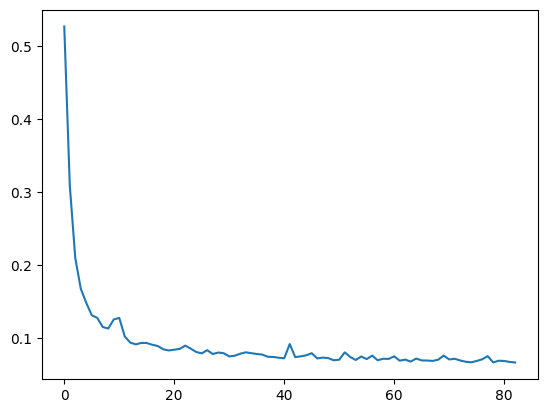

0.06616449511400652

In [ ]:
plt.plot(NMSE_test)
plt.show()
np.min(NMSE_test)

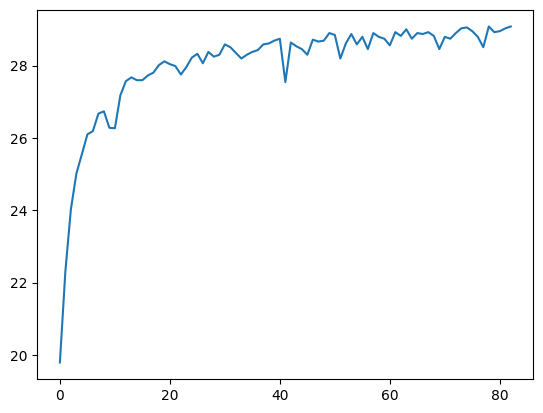

19.791530944625407

In [ ]:
plt.plot(PSNR_test)
plt.show()
np.min(PSNR_test)

## Plot losses

generator 0.0026588251
discrimnator 0.38466695



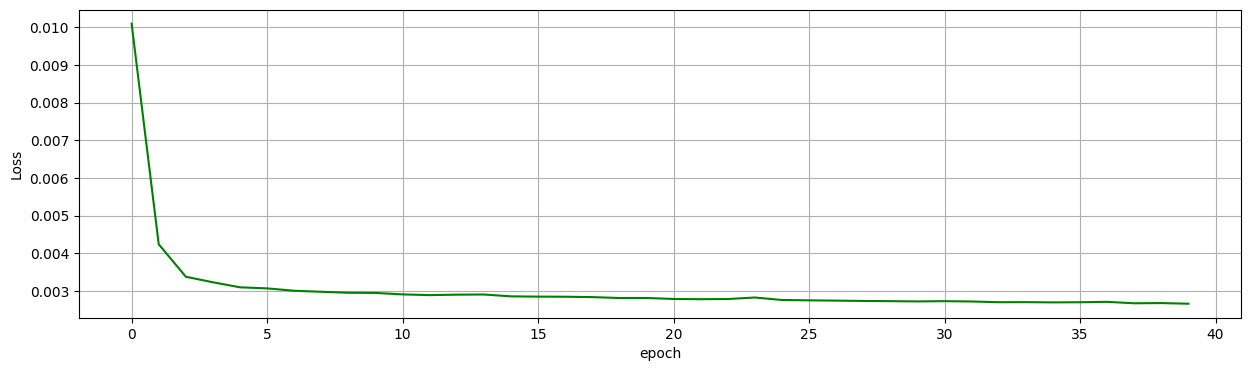

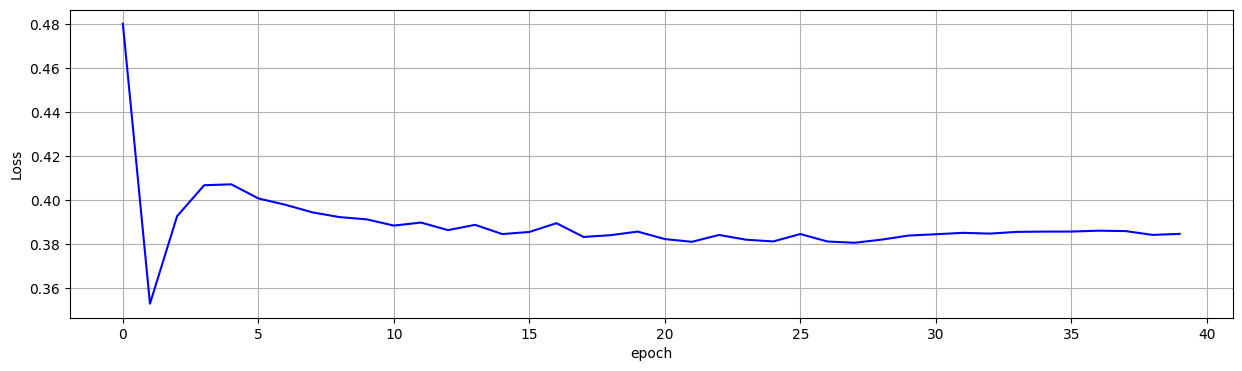

In [ ]:
print('generator',genloss[-1])
print('discrimnator',discloss[-1])
# NMSE_test = np.array(NMSE_test)

fig2, (generator) = plt.subplots(1,1, figsize=(15, 4))

plt.grid()
generator.plot(genloss,label="objectloss",linestyle='-',color='green')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.savefig('loss_gen_epoch40.png')

print()
fig, (discrimnator) = plt.subplots(1,1, figsize=(15, 4))

plt.grid()
discrimnator.plot(discloss,label="objectloss",color='blue')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.savefig('loss_disc_epoch40.png')


# plot test

In [ ]:
H_test,H_test_noisy = [],[]

In [ ]:
num_data_test_plot = 4
H_test_plot=np.zeros((num_data_test_plot,SIZE[0],SIZE[1],SIZE[2]), dtype=float)
H_test_noisy_plot=np.zeros((num_data_test_plot,SIZE[0],SIZE[1],SIZE[2]), dtype=float)


x = (255/NOISE_LEVEL)*1
for i in range(245,249):
  H = testset.__getitem__(i)[0]
  H_test_plot[i-245,:,:,:]= H
  N = np.random.normal(0, 1/x , size=(SIZE[0],SIZE[1], SIZE[2]))
  H_test_noisy_plot[i-245,:,:,:]= H + N

print(H_test_plot.shape,H_test_noisy_plot.shape)

(4, 3, 128, 128) (4, 3, 128, 128)


In [ ]:
H_test_plot=(torch.permute(torch.tensor(H_test_plot , dtype = torch.float32),(0,1,2,3))).to(device)
H_test_noisy_plot=torch.permute(torch.tensor(H_test_noisy_plot,dtype = torch.float32),(0,1,2,3)).to(device)
print(H_test_plot.shape,H_test_noisy_plot.shape)

torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128])


In [ ]:
gen.eval()
decoded_channel = gen(H_test_noisy_plot.to(device))

In [ ]:
def plot_image_test2(r,c,data):
  d=[]
  i = 0
  for k in range(r*c):
    image =data[k,:,:,:]
    image = np.transpose(image.cpu(),(1,2,0))
    d.append(image)
  f, axarr = plt.subplots(r,c)
  for row in range(r):
    for col in range(c):
      axarr[row,col].imshow(d[i])
      i += 1


In [ ]:
def plot_image_pred(r,c,data):
  d=[]
  i = 0
  for k in range(r*c):
    image =data[k,:,:,:]
    image = np.transpose(image,(1,2,0))
    d.append(image)
  f, axarr = plt.subplots(r,c)
  for row in range(r):
    for col in range(c):
      axarr[row,col].imshow(d[i])
      i += 1


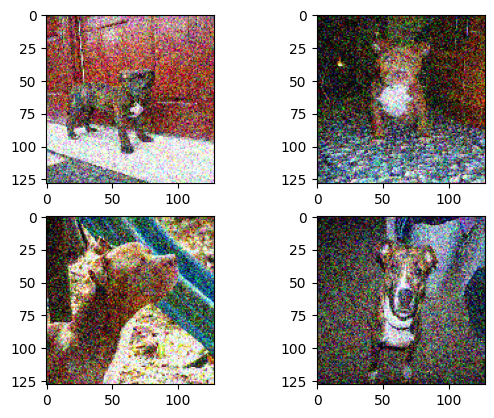

In [ ]:
plot_image_pred(2,2,decoded_channel.cpu().detach().numpy())
plt.savefig('predicted{}x{}and{}NOISE_LEVEL.png'.format(r,c,NOISE_LEVEL))

plot_image_test2(2,2,H_test_plot)
plt.savefig('test{}x{}_orginal {}NOISE_LEVEL.png'.format(r,c,NOISE_LEVEL))

plot_image_test2(2,2,H_test_noisy_plot)
plt.savefig('test{}x{}_corrupted {}NOISE_LEVEL.png'.format(r,c,NOISE_LEVEL))

In [ ]:
import os
import shutil
os.mkdir('/content/image')
# shutil.move('/content/loss_disc_epoch40.png',  '/content/image')
# shutil.move('/content/loss_gen_epoch40.png',  '/content/image')
shutil.move('/content/predicted2x2and{}NOISE_LEVEL.png'.format(NOISE_LEVEL),  '/content/image')
shutil.move('/content/test2x2_corrupted {}NOISE_LEVEL.png'.format(NOISE_LEVEL),  '/content/image')
shutil.move('/content/test2x2_orginal {}NOISE_LEVEL.png'.format(NOISE_LEVEL),  '/content/image')
# shutil.move('/content/train2x2_corrupted {}NOISE_LEVEL.png'.format(NOISE_LEVEL),  '/content/image')
# shutil.move('/content/train2x2orginal {}NOISE_LEVEL.png'.format(NOISE_LEVEL),  '/content/image')
shutil.make_archive('images_with "{}" NOISE_LEVEL ##Oxford##'.format(NOISE_LEVEL), 'zip','/content/image' )


'/content/images_with "40" NOISE_LEVEL ##Oxford##.zip'